In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings
import matplotlib.pyplot as plt
import copy, time, glob, os, sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from helpers import *
from utilities import *
from model import rnn_horizon
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

C:\Users\sshi\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load raw data

In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(3)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Get some suplementary data

In [3]:
# play id to play roles/positions
id_role = id_position(events_df)
check_game_roles_duplicates(id_role)

# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order
# ddentify defending and offending runs (this is included in process_moments)
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

# home and visitor ids
homeid = events_df.loc[0].home['teamid']
awayid = events_df.loc[0].visitor['teamid']

#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [44]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
events = filter_event_type(events_df, discard_event)
print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
# subsample_factor = 0
# single_game = get_game_data(events, id_role, role_order, court_index, game_id, 
#                             event_threshold=10, subsample_factor=subsample_factor)
# print('Final number of events:', len(single_game))
subsample_factor = 0
single_game, single_game_balls = get_game_data_ra(events, court_index, game_id, 
                                                  event_threshold=10, subsample_factor=subsample_factor)
print('Final number of events:', len(single_game))

# get player velocity
fs_base = 1./25 # 1/25 sec/frame   or  25 frames/sec
fs = fs_base * subsample_factor if subsample_factor != 0 else fs_base
single_game = [get_velocity(i, fs, mode=1) for i in single_game]
n_events = len(single_game)

# get basketball velocity
single_game_balls = [np.concatenate([i[:-1, :], get_velocity(i, fs, mode=0)], axis=1) for i in single_game_balls]

After filtering events has shape: (134, 8)
Final number of events: 165


In [24]:
single_game[0].shape

(37, 40)

In [20]:
single_game_balls[0].shape

(37, 3)

#### Role assignment and reorder moment

In [50]:
# first prepare data
n_defend = 5
n_offend = 5
n_ind = 4

# length for each moment
event_lengths = np.array([len(i) for i in single_game])
# repeat the event_lengths 5 times in order to match the unstack later on with moments
event_lengths_repeat = np.concatenate([event_lengths for _ in range(n_defend)], axis=0)
# all the moments
all_moments = np.concatenate(single_game, axis=0)
all_moments_vel = np.concatenate(single_game, axis=0) # vel
# we only need the first 5 players x,y coordindates
# defend
all_defend_moments = all_moments[:, :n_ind*n_defend]
# all_defend_moments_vel = all_moments_vel[:, :2*n_defend]
# offend
all_offend_moments = all_moments[:, n_ind*n_offend:]
# all_offend_moments_vel = all_moments_vel[:, 2*n_offend:]

# flattened
all_defend_moments_ = np.concatenate([all_defend_moments[:, i:i+n_ind] for i in range(0, n_ind*n_defend, n_ind)], axis=0)
all_offend_moments_ = np.concatenate([all_offend_moments[:, i:i+n_ind] for i in range(0, n_ind*n_offend, n_ind)], axis=0)

# all_defend_moments_vel_ = np.concatenate([all_defend_moments_vel[:, i:i+2] for i in range(0, 2*n_defend, 2)], axis=0)
# all_offend_moments_vel_ = np.concatenate([all_offend_moments_vel[:, i:i+2] for i in range(0, 2*n_offend, 2)], axis=0)

In [51]:
all_defend_moments_[:2]

array([[11.15334, 21.35529, -4.02675, -1.01925],
       [10.99227, 21.31452, -2.59725,  0.0395 ]])

In [52]:
all_offend_moments_[:2]

array([[24.18381, 44.21187,  1.89025, -2.18575],
       [24.25942, 44.12444,  1.33325, -3.52625]])

In [53]:
# create hmm model
n_comp = 7
n_mix = None
RA = RoleAssignment()

In [54]:
# train
defend_state_sequence_, defend_means, defend_covs, _ = RA.train_hmm(all_defend_moments_, event_lengths_repeat, n_comp, n_mix)
offend_state_sequence_, offend_means, offend_covs, _ = RA.train_hmm(all_offend_moments_, event_lengths_repeat, n_comp, n_mix)
# get role orders
_, defend_roles = RA.assign_roles(all_defend_moments_, all_defend_moments, defend_means, event_lengths)
_, offend_roles = RA.assign_roles(all_offend_moments_, all_offend_moments, offend_means, event_lengths)

         1    -1526457.8325             +nan
         2    -1268924.5854     +257533.2471
         3    -1200828.2524      +68096.3330
         4    -1172055.6233      +28772.6291
         5    -1168202.8601       +3852.7632
         6    -1166918.4365       +1284.4236
         7    -1166079.8787        +838.5578
         8    -1165555.5242        +524.3545
         9    -1165269.0194        +286.5048
        10    -1165082.1474        +186.8720
        11    -1164971.9147        +110.2327
        12    -1164914.3671         +57.5477
        13    -1164891.1977         +23.1694
        14    -1164881.8610          +9.3367
        15    -1164877.5057          +4.3553
        16    -1164875.3154          +2.1902
        17    -1164874.1176          +1.1978
        18    -1164873.3956          +0.7220
        19    -1164872.9145          +0.4811
        20    -1164872.5633          +0.3512
        21    -1164872.2874          +0.2759
        22    -1164872.0588          +0.2287
        23

In [55]:
defend_pos_vel = order_moment_ra([i[:, :n_ind*5] for i in single_game], defend_roles)
offend_pos_vel = order_moment_ra([i[:, n_ind*5:] for i in single_game], offend_roles)

In [56]:
single_game_balls[0].shape

(37, 6)

In [57]:
single_game = [np.concatenate([defend_pos_vel[i], offend_pos_vel[i], single_game_balls[i]], axis=1) for i in range(n_events)]

In [58]:
single_game[0].shape

(37, 62)

In [31]:
all_roles = [np.concatenate([defend_roles[i], offend_roles[i]], axis=1) for i in range(len(single_game))]

In [32]:
all_roles[0].shape

(37, 10)

In [33]:
len(all_roles)

165

In [34]:
n_events

165

#### Show the plot, for the sake of comparison with processed moment later on

In [15]:
# Plot = PlotGame(game_id, main_dir, game_dir)
# # for i in range(plotn): 
# Plot.load_moment2img(game_data, event_number=0, moment_number=0, return_img=True)

In [16]:
# # manual plot check
# plot_check(single_game, plt_ind=0)

#### Create label, train and test set

In [17]:
sequence_length = 30
overlap = 15
# pad short sequence and chunk long sequence with overlaps
train, target = get_sequences(single_game, sequence_length, overlap)

In [18]:
# create train and test set
p = 0.8 # train percentage
divider = int(len(train)*p)
train_game, test_game = train[:divider], train[divider:]
train_target, test_target = target[:divider], target[divider:]

In [19]:
len(train_game), len(test_game)

(1067, 267)

In [20]:
train_game[0].shape

(29, 56)

#### Build graph and starts training

In [21]:
tf.reset_default_graph()
# use training start time as the unique naming
train_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
logs_path = './train_logs/'

# hyper-parameters
# num_layers = 2
state_size = 128
batch_size = 32
dimx = 56
dimy = 2
learning_rate = 0.001
n_epoch = int(1e3)
true_seq_len = sequence_length-1

# lstm cells
lstm1 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
# lstm1 = tf.nn.rnn_cell.DropoutWrapper(lstm1, output_keep_prob=0.8)

lstm2 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
# lstm2 = tf.nn.rnn_cell.DropoutWrapper(lstm2, output_keep_prob=0.8)

lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm1, lstm2])

# a single lstm layer
# lstm_cell = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
# lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=0.7)

# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

# input placeholders
h = tf.placeholder(tf.int32)
seq_len = tf.placeholder(tf.int32)
# X = tf.placeholder(tf.float32, [batch_size, None, dimx], name = 'train_input')
# Y = tf.placeholder(tf.float32, [batch_size, None, dimy], name = 'train_label')
X = tf.placeholder(tf.float32, [batch_size, true_seq_len, dimx], name = 'train_input')
Y = tf.placeholder(tf.float32, [batch_size, true_seq_len, dimy], name = 'train_label')
# rnn structure
# output, last_states = rnn_horizon(cell = lstm_cell, 
#                                   initial_state = initial_state, 
#                                   input_ = X,
#                                   batch_size = batch_size,
#                                   seq_lengths = seq_len,
#                                   horizon = h,
#                                   output_dim = dimy)

output1, last_states = tf.nn.dynamic_rnn(cell=lstm_cell,
                                        inputs = X,
                                        sequence_length=seq_len,
                                        initial_state=initial_state)

output = tf.contrib.layers.fully_connected(inputs=output1, num_outputs=dimy)
# output as the prediction
print('output shape, last_states', output.shape, last_states)
pred = output
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))

# tensorboard's graph visualization more convenient
with tf.name_scope('MSEloss'):
    # loss (also add regularization on params)
    tv = tf.trainable_variables()
    # l2 weight loss
#     regularization_cost = tf.reduce_sum([tf.nn.l2_loss(v) for v in tv])
    # l1 loss
    l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
    regularization_cost = tf.contrib.layers.apply_regularization(l1_regularizer, tv)

    loss = tf.losses.mean_squared_error(Y, pred) + regularization_cost
    
    # no weight loss
#     loss = tf.losses.mean_squared_error(Y, pred)

with tf.name_scope('Adam'):
    # optimzier
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
# initialize variables
init = tf.global_variables_initializer()
# create a summary to monitor cost tensor
train_summary = tf.summary.scalar("TrainMSEloss", loss)
valid_summary = tf.summary.scalar("ValidMSEloss", loss)
# # Merge all summaries into a single op
# merged_summary_op = tf.summary.merge_all()


# session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# initializing the variables
sess.run(init)
# op to write logs to Tensorboard
train_writer = tf.summary.FileWriter(logs_path+'/train'+train_time, graph=tf.get_default_graph())
valid_writer = tf.summary.FileWriter(logs_path+'/valid'+train_time, graph=tf.get_default_graph())

# ===============================================================================================

# start training
printn = int(1e2)    # how many epochs we print
# horizon = [2, 4, 8, 12, 16, 20, 25]
horizon = [1]
t_int = time.time()
train_step = 0
valid_step = 0
for k in horizon:
    # look-ahead horizon
#     seq_len = horizon[k]
#     seq_len =  # because we dropped one when creating targets
    print('Horizon {0:} {1:}'.format(seq_len, '='*10))

    for epoch in range(n_epoch):
        epoch_loss =0.
        # number of train batches
        n_train_batch = len(train_game)//batch_size
        t1 = time.time()
        for batch in iterate_minibatches(train_game, train_target, batch_size, shuffle=False):
            train_xi, train_yi = batch
            p, l, _, train_sum = sess.run([output, loss, opt, train_summary], 
                                          feed_dict={X: train_xi, Y: train_yi, 
                                                     seq_len:true_seq_len,
                                                     h: 2})
            train_writer.add_summary(train_sum, train_step)
            epoch_loss += l/n_train_batch
            train_step += 1
        # print out info
        if epoch%printn ==0:
            # number of validation batches
            n_val_batch = len(test_game)//batch_size
            t2 = time.time()
            valid_loss = 0
            for test_batch in iterate_minibatches(test_game, test_target, batch_size, shuffle=False):
                val_xi, val_yi = test_batch
                val_l, valid_sum = sess.run([loss, valid_summary], 
                                            feed_dict={X: val_xi, Y: val_yi, 
                                                       seq_len:true_seq_len,
                                                       h: 2})

                valid_writer.add_summary(valid_sum, valid_step)
                valid_loss += val_l/n_val_batch
                valid_step += printn
            print('Epoch {0:<4d} | loss: {1:<8.2f} | time took: {2:<.2f}s '
                  '| validation loss: {3:<8.2f}'.format(epoch, epoch_loss, (t2-t1), valid_loss))
                

t_end = time.time()
print('Total time took: {0:<.2f}hrs'.format((time.time()-t_int)/60/60))

output shape, last_states (32, 29, 2) (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(32, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(32, 128) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(32, 128) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(32, 128) dtype=float32>))
label shape:(32, 29, 2) | output prediction shape: (32, 29, 2)
Horizon Tensor("Placeholder_1:0", dtype=int32) ==========
Epoch 0    | loss: 231.87   | time took: 0.72s | validation loss: 158.90  
Epoch 100  | loss: 7.85     | time took: 0.54s | validation loss: 10.80   
Epoch 200  | loss: 6.92     | time took: 0.54s | validation loss: 10.02   
Epoch 300  | loss: 6.06     | time took: 0.54s | validation loss: 8.95    
Epoch 400  | loss: 5.92     | time took: 0.54s | validation loss: 8.73    
Epoch 500  | loss: 5.38     | time took: 0.54s | validation loss: 8.24    
Epoch 600  | loss: 5.32     | time took: 0.54s | validation loss: 8.67    
Epoch 700  | loss: 

### Check model on train set (per player)

rand checking index: 9 out of 33


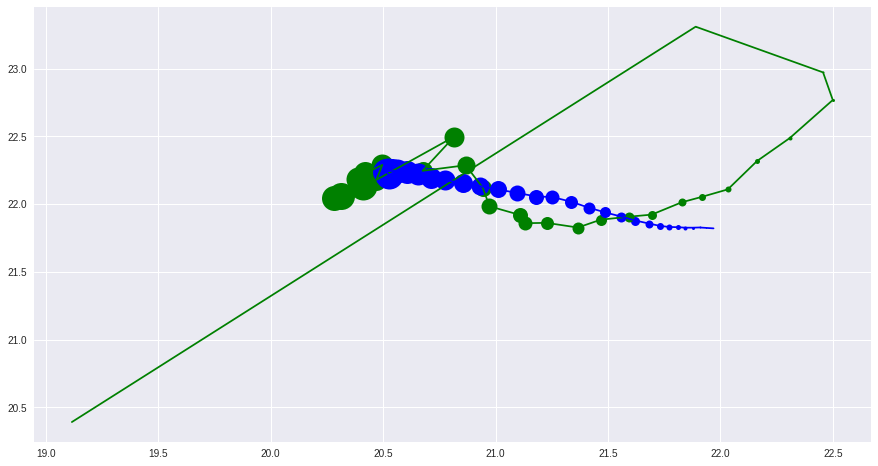

In [22]:
# use while loop to make sure the 
train_batches = get_minibatches(train_game, train_target, batch_size, shuffle=False)

check_ind = np.random.randint(0, len(train_game)//batch_size)
print('rand checking index: {0:} out of {1:}'.format(check_ind, len(train_game)//batch_size))

input_xi, output_yi = train_batches
y_pred = sess.run([output], feed_dict={X: input_xi[check_ind], seq_len:true_seq_len, h: 2})#, Y: train_yi, h:2})
y_true = output_yi[check_ind]
    
y_pred = y_pred[0][0].reshape(-1,2)
y_true = y_true[0].reshape(-1,2)

plt.figure(figsize=(15,8))
for k in range(0, len(y_pred)):
    plt.plot(y_pred[:, 0][k], y_pred[:, 1][k], linestyle="None", marker="o", markersize=k, color='g')
    plt.plot(y_true[:, 0][k], y_true[:, 1][k], linestyle="None", marker="o", markersize=k, color='b')

plt.plot(y_pred[:, 0], y_pred[:, 1],'g', y_true[:,0], y_true[:,1], 'b')#, pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

In [23]:
y_pred.shape

(29, 2)

In [24]:
y_true.shape

(29, 2)

In [25]:
len(train_game)//batch_size

33

#### Check model on test set

rand checking index: 5 out of 8


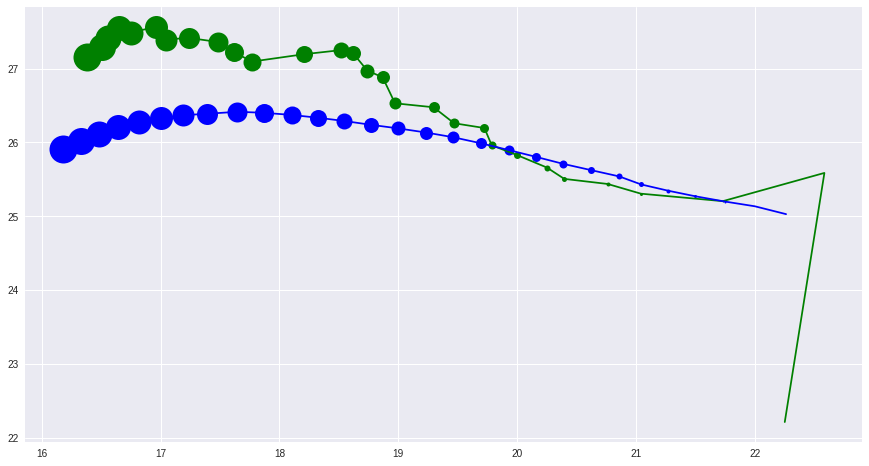

In [26]:
# use while loop to make sure the 
test_batches = get_minibatches(test_game, test_target, batch_size, shuffle=False)

check_ind = np.random.randint(0, len(test_game)//batch_size)
print('rand checking index: {0:} out of {1:}'.format(check_ind, len(test_game)//batch_size))

input_xi, output_yi = test_batches
y_pred = sess.run([output], feed_dict={X: input_xi[check_ind], seq_len:true_seq_len, h: 2})#, Y: train_yi, h:2})
y_true = output_yi[check_ind]
    
y_pred = y_pred[0][0].reshape(-1,2)
y_true = y_true[0].reshape(-1,2)

plt.figure(figsize=(15,8))
for k in range(0, len(y_pred)):
    plt.plot(y_pred[:, 0][k], y_pred[:, 1][k], linestyle="None", marker="o", markersize=k, color='g')
    plt.plot(y_true[:, 0][k], y_true[:, 1][k], linestyle="None", marker="o", markersize=k, color='b')

plt.plot(y_pred[:, 0], y_pred[:, 1],'g', y_true[:,0], y_true[:,1], 'b')#, pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning
    - from each sample to next sample theres not much change, subsample them 

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 